# **Topic Modelling Validation**

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import adjusted_rand_score, jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import random
import matplotlib.pyplot as plt

In [9]:
# Load Dataset
df = pd.read_csv('/Users/tharanidissanayake/Downloads/labelled_data.csv')

In [4]:
# Vectorize Text Data
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 1))
X_counts = count_vectorizer.fit_transform(df['spacy_tokens'])
feature_names = count_vectorizer.get_feature_names_out()

In [5]:
# Randomly Select 50 Reviews
random.seed(42)
subset_reviews = df.sample(n=50, random_state=42).reset_index(drop=True)

In [6]:
# Exclude these reviews from the dataset for training
remaining_reviews = df[~df.index.isin(subset_reviews.index)]

In [10]:
# Define the LDA model and parameters for grid search
lda = LatentDirichletAllocation(random_state=42)
param_grid = {
    'n_components': [5, 10, 15, 20],
    'learning_method': ['batch', 'online'],
    'max_iter': [5, 10, 15]
}

# Perform grid search
grid_search = GridSearchCV(lda, param_grid, n_jobs=-1)
grid_search.fit(X_counts)

# Best parameters
print("Best LDA Parameters:", grid_search.best_params_)

Best LDA Parameters: {'learning_method': 'online', 'max_iter': 15, 'n_components': 5}


In [11]:
# Train the LDA model using the best parameters found
lda_model = grid_search.best_estimator_
lda_model.fit(X_counts)


LatentDirichletAllocation(learning_method='online', max_iter=15, n_components=5,
                          random_state=42)

In [12]:
# Assign Topics to the Selected Reviews
subset_counts = count_vectorizer.transform(subset_reviews['spacy_tokens'])
subset_topics_probabilities = lda_model.transform(subset_counts)
subset_assigned_topics = subset_topics_probabilities.argmax(axis=1)

In [13]:
# Display Topics for Manual Interpretation
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

display_topics(lda_model, feature_names, 10)

Topic 1:
hotel, one, two, room, staff, would, five, time, day, three


Topic 2:
tea, food, sri, place, villa, resort, curry, lankan, garden, day


Topic 3:
room, night, bed, breakfast, bathroom, water, one, shower, could, area


Topic 4:
staff, stay, hotel, service, food, experience, thank, special, made, amazing


Topic 5:
room, good, hotel, staff, great, view, nice, place, food, friendly




In [14]:
# Map Topics to Aspect Labels (Manual Mapping)
topic_to_aspect = {
    1: "Accommodation",
    2: "Dining & Service",
    3: "Scenic Views & Activities",
    4: "Recommendations & Hospitality",
    5: "Food & Room Facilities",
    6: "Cleanliness & Hotel Experience",
    7: "Beach & Coastal Stay",
    8: "Family Stay & Comfort",
    9: "Scenic Locations & Pool",
    10: "Bathroom Facilities",
    11: "Booking & Stay Experience",
    12: "Hotel Amenities",
    13: "Food & Dining",
    14: "Local Culture",
    15: "Customer Service",
    16: "Nature & Wellness"
}
predicted_aspects = [topic_to_aspect[topic + 1] for topic in subset_assigned_topics]


In [15]:
# Manually Label the Reviews
manual_labels = []
for review in subset_reviews['review_text']:
    print(f"Review: {review}")
    label = input("Manual aspect label(s): ")
    manual_labels.append(label.split(','))  # Allow multiple labels

Review: best hotel visited free time good hospitality good ambiance nice view room good working room heater ancient breakfast clean tidy friendly staff close kandy city strongly recommend
Review: stayed six night lived like prince boutique hotel virtually place food fantastic pool alone spacious well appointed room outdoor spa host umesh quiet gracious helped u book day trip sigiriya local transport also came chocolate ice cream dessert day day contact breakfast dinner beer local advice danushka mahesh give man pay rise service excellent
Review: arrived two little kid warmly welcomed cabana food great recommend place especially active one sea rough matter anyway pool definitely perfect spot surfing
Review: great location charming setting created middle everything cute log cabin make feel like early settler billards table tea great early evening break dinner staff great went way make sure happy
Review: want super relaxing place stay choose hotel flower garden unawatuna stayed cabana ful

In [16]:
# Add the manual labels to the DataFrame
subset_reviews['manual_labels'] = manual_labels

# Save the DataFrame to a CSV file
output_file = '/Users/tharanidissanayake/Downloads/manual_labels.csv'  
subset_reviews.to_csv(output_file, index=False)

In [17]:
# Compare Predicted and Manual Labels
subset_reviews['manual_labels'] = manual_labels
subset_reviews['predicted_labels'] = predicted_aspects

# Validation Metrics

In [18]:
# Flatten labels for metrics computation
mlb = MultiLabelBinarizer()
manual_labels_binarized = mlb.fit_transform(subset_reviews['manual_labels'])
predicted_labels_binarized = mlb.transform([[aspect] for aspect in subset_reviews['predicted_labels']])

In [20]:
# Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(manual_labels_binarized.argmax(axis=1), predicted_labels_binarized.argmax(axis=1))
print(f"Adjusted Rand Index (ARI): {ari_score}")


Adjusted Rand Index (ARI): 0.11812081744800962


In [21]:
# Jaccard Coefficient (for multi-label comparison)
jaccard_scores = []
for i in range(len(manual_labels_binarized)):
    jaccard_scores.append(jaccard_score(manual_labels_binarized[i], predicted_labels_binarized[i]))
jaccard_average = np.mean(jaccard_scores)
print(f"Jaccard Coefficient (Average): {jaccard_average}")

Jaccard Coefficient (Average): 0.6033333333333332


# Visualize the Validation Metrics

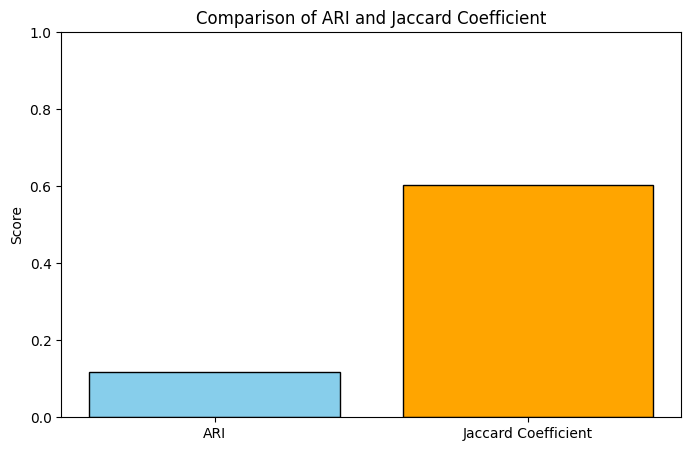

In [24]:
# Bar Plot: ARI vs. Jaccard Coefficient
scores = [ari_score, jaccard_average]
metrics = ['ARI', 'Jaccard Coefficient']

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['skyblue', 'orange'], edgecolor='black')
plt.ylim(0, 1)
plt.title('Comparison of ARI and Jaccard Coefficient')
plt.ylabel('Score')
plt.show()

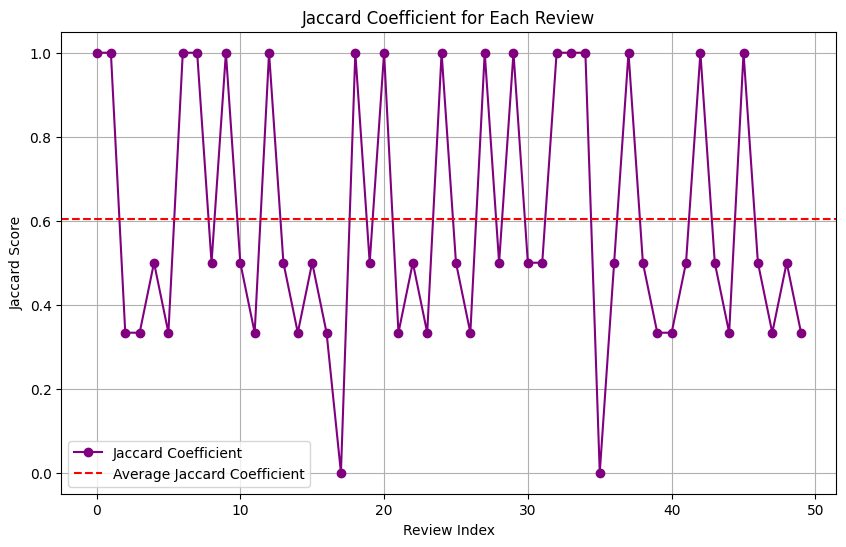

In [23]:
# Line Plot: Jaccard Scores for Each Review
plt.figure(figsize=(10, 6))
plt.plot(range(len(jaccard_scores)), jaccard_scores, marker='o', linestyle='-', color='purple', label='Jaccard Coefficient')
plt.axhline(y=jaccard_average, color='red', linestyle='--', label='Average Jaccard Coefficient')
plt.title('Jaccard Coefficient for Each Review')
plt.xlabel('Review Index')
plt.ylabel('Jaccard Score')
plt.legend()
plt.grid()
plt.show()

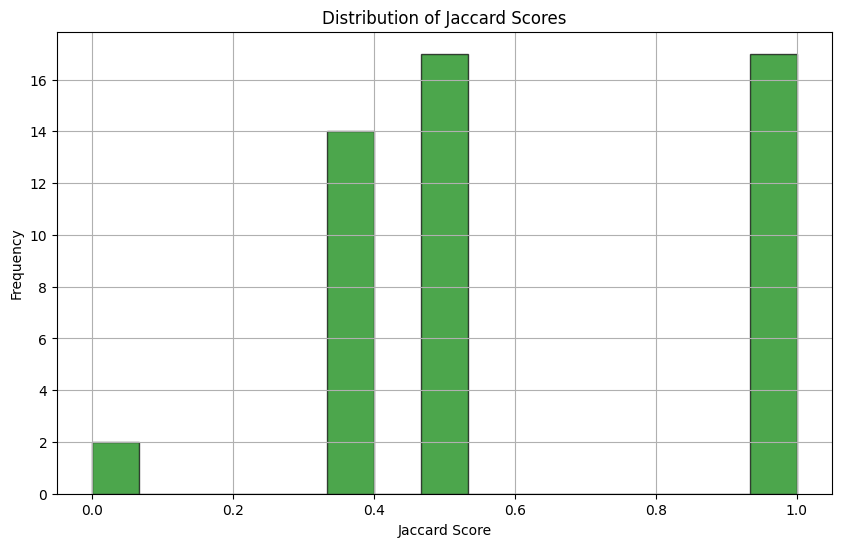

In [25]:
# Histogram: Distribution of Jaccard Scores
plt.figure(figsize=(10, 6))
plt.hist(jaccard_scores, bins=15, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Jaccard Scores')
plt.xlabel('Jaccard Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()